In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qibo import models, hamiltonians, symbols, callbacks, set_backend

# if nqubits >= 20 set qibojit as backend
set_backend('numpy')

[Qibo 0.2.4|INFO|2024-01-08 09:01:56]: Using numpy backend on /CPU:0


In [2]:
# definition of the problem
nqubits = 3
dt = 0.1
final_time = 20

# parameters used into the scheduling
nparams = 5
np.random.seed(42)
params = np.random.randn(nparams)

# building hamiltonians using symbols
form0 = np.prod([symbols.X(i) for i in range(nqubits)])
form1 = np.prod([symbols.Z(i) for i in range(nqubits)])

h0 = hamiltonians.SymbolicHamiltonian(form=form0)
h1 = hamiltonians.SymbolicHamiltonian(form=form1)

# ground states
g0 = h0.ground_state()
g1 = h1.ground_state()

# define a random observable
# a Z hamiltonian for example
obs = hamiltonians.Z(nqubits=nqubits)

[Qibo 0.2.4|WARNING|2024-01-08 09:01:56]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.4|WARNING|2024-01-08 09:01:56]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


In [3]:
# some infos
print(f'g0: {g0}')
print(f'g1: {g1}')
print('Energy at g0:', obs.expectation(g0))
print('Energy at g1:', obs.expectation(g1))

g0: [-0.70710678+0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.70710678+0.j]
g1: [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
Energy at g0: 0.0
Energy at g1: -1.0


In [4]:
# defining a scheduling
def schedule(params):
    """Generates adiabatic evolution scheduling function."""
    nparams = len(params)

    def poly(t):
        """General polynomial scheduling satisfying s(0)=0 and s(1)=1"""
        f = np.sum(  (t**np.arange(1,1+nparams)*params) )
        f /= np.sum(params)
        return f
    
    return poly


def track_energy(energy):
    """Plots obs energy during the evolution."""

    times = np.linspace(0, 1, int(final_time/dt)+1)

    plt.figure(figsize=(8,5))
    plt.title('Energy during the evolution')
    plt.plot(times, energy, c='purple', lw=2, alpha=0.65, label='Energy')
    plt.grid(True)
    plt.xlabel(r'$\tau$')
    plt.ylabel('Energy')
    plt.legend()
    plt.show()


In [5]:
# generate a poly schedule
s = schedule(params)

# we keep track of obs energy on the evolved state
energies = callbacks.Energy(obs)

# we keep track of the h1 energy on the evolved state
energies = callbacks.Energy(h1)

# define the evolution object
evolution = models.AdiabaticEvolution(h0=h0, h1=h1, s=s, dt=dt, callbacks=[energies], solver='exp')

# evolution at final_time returns the final evolved state
final_state = evolution(final_time=final_time)

print(f'Final state: {final_state}')

Final state: [ 0.03609809-0.00305163j  0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j         -0.05247307-0.99796503j]


In [6]:
# translating the hamiltonian into a circuit via Trotter decomposition
c = evolution.hamiltonian.circuit(15)
print(c.draw())

q0: ─U─U─
q1: ─U─U─
q2: ─U─U─


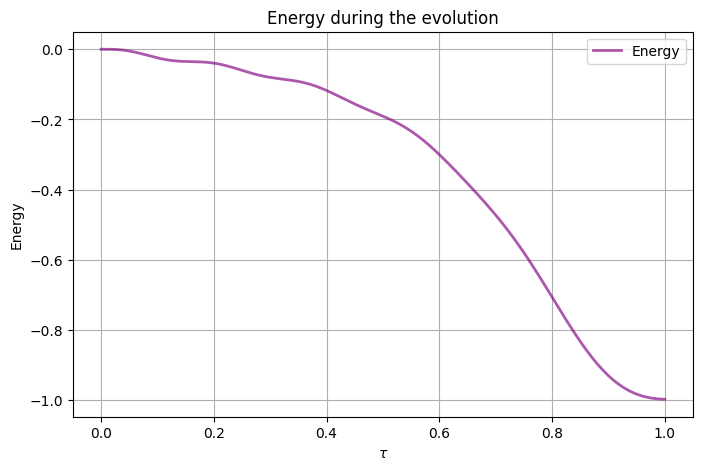

In [7]:
track_energy(energies[:])